In [2]:
import numpy as np

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from tools.plot_utils import plot_pretty
plot_pretty()
%matplotlib inline

import sys
sys.path.append('/home/zzbenjamin94/Desktop/Astronomy/Research/DES_Galaxy_Cluster')
from mpl_toolkits.mplot3d import Axes3D
from tools.setup.setup import tools_home_dir, home_dir
import astropy.io.fits as fits
shapedir = home_dir()+'output/buzzard/halo_shape/'
tpltdir = home_dir() + 'output/lmda_cosi_chains/miscentering/'
buzzdir = home_dir() + 'output/buzzard/'
toolsdir = tools_home_dir()
homedir = home_dir()

import astropy.io.fits as pyfits
import ConfigParser
import healpy as hp
import treecorr
import os

from repo.halo_shape.halo_shape_stats_backend import kmeans_stats, student_t_test
from repo.halo_shape.read_shape_param import halo_bin_stat, read_shape_param

## Import Catalogs

In [40]:
#Miscentering cut
import pickle

redM_halos = homedir + 'output/buzzard/redM_halos_fullmatchingparams_v1.2_redMv1.6.data'

infile = open(redM_halos,'rb')
redM_halos = pickle.load(infile)
infile.close()

redM_halos = redM_halos.view(np.recarray)
print redM_halos.dtype
print len(redM_halos)

(numpy.record, [('GALAXY_ID', '>i4'), ('HALOID', '>i4'), ('DESCID', '>i8'), ('RA_OBS', '>f8'), ('DEC_OBS', '>f8'), ('TRA', '>f8'), ('TDEC', '>f8'), ('Z', '>f8'), ('MVIR', '>f8'), ('VMAX', '>f8'), ('VRMS', '>f8'), ('RVIR', '>f8'), ('RS', '>f8'), ('NP', '>f8'), ('PX', '>f8'), ('PY', '>f8'), ('PZ', '>f8'), ('VX', '>f8'), ('VY', '>f8'), ('VZ', '>f8'), ('JX', '>f8'), ('JY', '>f8'), ('JZ', '>f8'), ('SPIN', '>f8'), ('RS_KLYPIN', '>f8'), ('MVIR_ALL', '>f8'), ('M200B', '>f8'), ('M200C', '>f8'), ('M500C', '>f8'), ('M2500C', '>f8'), ('XOFF', '>f8'), ('VOFF', '>f8'), ('SPIN_BULLOCK', '>f8'), ('B_TO_A', '>f8'), ('C_TO_A', '>f8'), ('PID', '>i8'), ('LUMTOT', '>f8'), ('LUM20', '>f8'), ('LBCG', '>f8'), ('NGALS', '>i8'), ('N18', '>i8'), ('N19', '>i8'), ('N20', '>i8'), ('N21', '>i8'), ('N22', '>i8'), ('matching_ID', '<i8'), ('MEM_MATCH_ID', '<i8'), ('LAMBDA_CHISQ', '<f8'), ('RA_REDM', '<f8'), ('DEC_REDM', '<f8'), ('q', '<f8'), ('s', '<f8'), ('cosi', '<f8'), ('centered_flag', '<i8')])
13628
19.94246482849

## Binning

In [52]:
from repo.halo_shape.read_shape_param import halo_bin_stat

#Bin by richness
lmda_max = np.max(redM_halos.LAMBDA_CHISQ)
z_max = np.max(redM_halos.Z)

lmda_bins = [[20,30],[30,50],[50,lmda_max]] #upper limit must match lower limit of next bin
z_bins = [[0.0,0.3],[0.3,0.5],[0.5, z_max]]

print lmda_bins[0][0]

num_lmda_bins = len(lmda_bins)
num_z_bins = len(z_bins)
lmda_bins_ind = halo_bin_stat(redM_halos.LAMBDA_CHISQ, lmda_bins)

ind_bin_2d = [[ [] for j in range(num_z_bins)] for i in range(num_lmda_bins)]
for i, lmda_bin_ind in enumerate(lmda_bins_ind):
    z_bins_ind = halo_bin_stat(redM_halos.Z[lmda_bin_ind], z_bins)
    #Convert list of arrays to list of lists
    z_bins_ind = [l.tolist() for l in z_bins_ind]
    z_bins_ind = [lmda_bin_ind[z_bin_ind] for j,z_bin_ind in enumerate(z_bins_ind)] #Check if this logic makes sense
    ind_bin_2d[i][:] = z_bins_ind
    print len(ind_bin_2d[i][0]), len(ind_bin_2d[i][1]), len(ind_bin_2d[i][2])
    
print "Maximum redshift after cuts is ", z_max
print 'Maximum richness after cuts is ', lmda_max

20
455 2488 3143
206 1921 2976
55 854 1524
Maximum redshift after cuts is  0.7419188022613525
Maximum richness after cuts is  303.0442810058594
20


In [54]:
#Testing 
redM_halos_bin = redM_halos[ind_bin_2d[2][2]]
z_bin_max = np.max(redM_halos_bin.Z); z_bin_min = np.min(redM_halos_bin.Z)
lmda_bin_max = np.max(redM_halos_bin.LAMBDA_CHISQ); lmda_bin_min = np.min(redM_halos_bin.LAMBDA_CHISQ)
print z_bin_min, z_bin_max
print lmda_bin_min, lmda_bin_max

0.5000817179679871 0.7318050861358643
50.01001739501953 216.5333251953125


## Plotting HMF

## Plotting HMF for centered clusters -- binned by richness and redshift

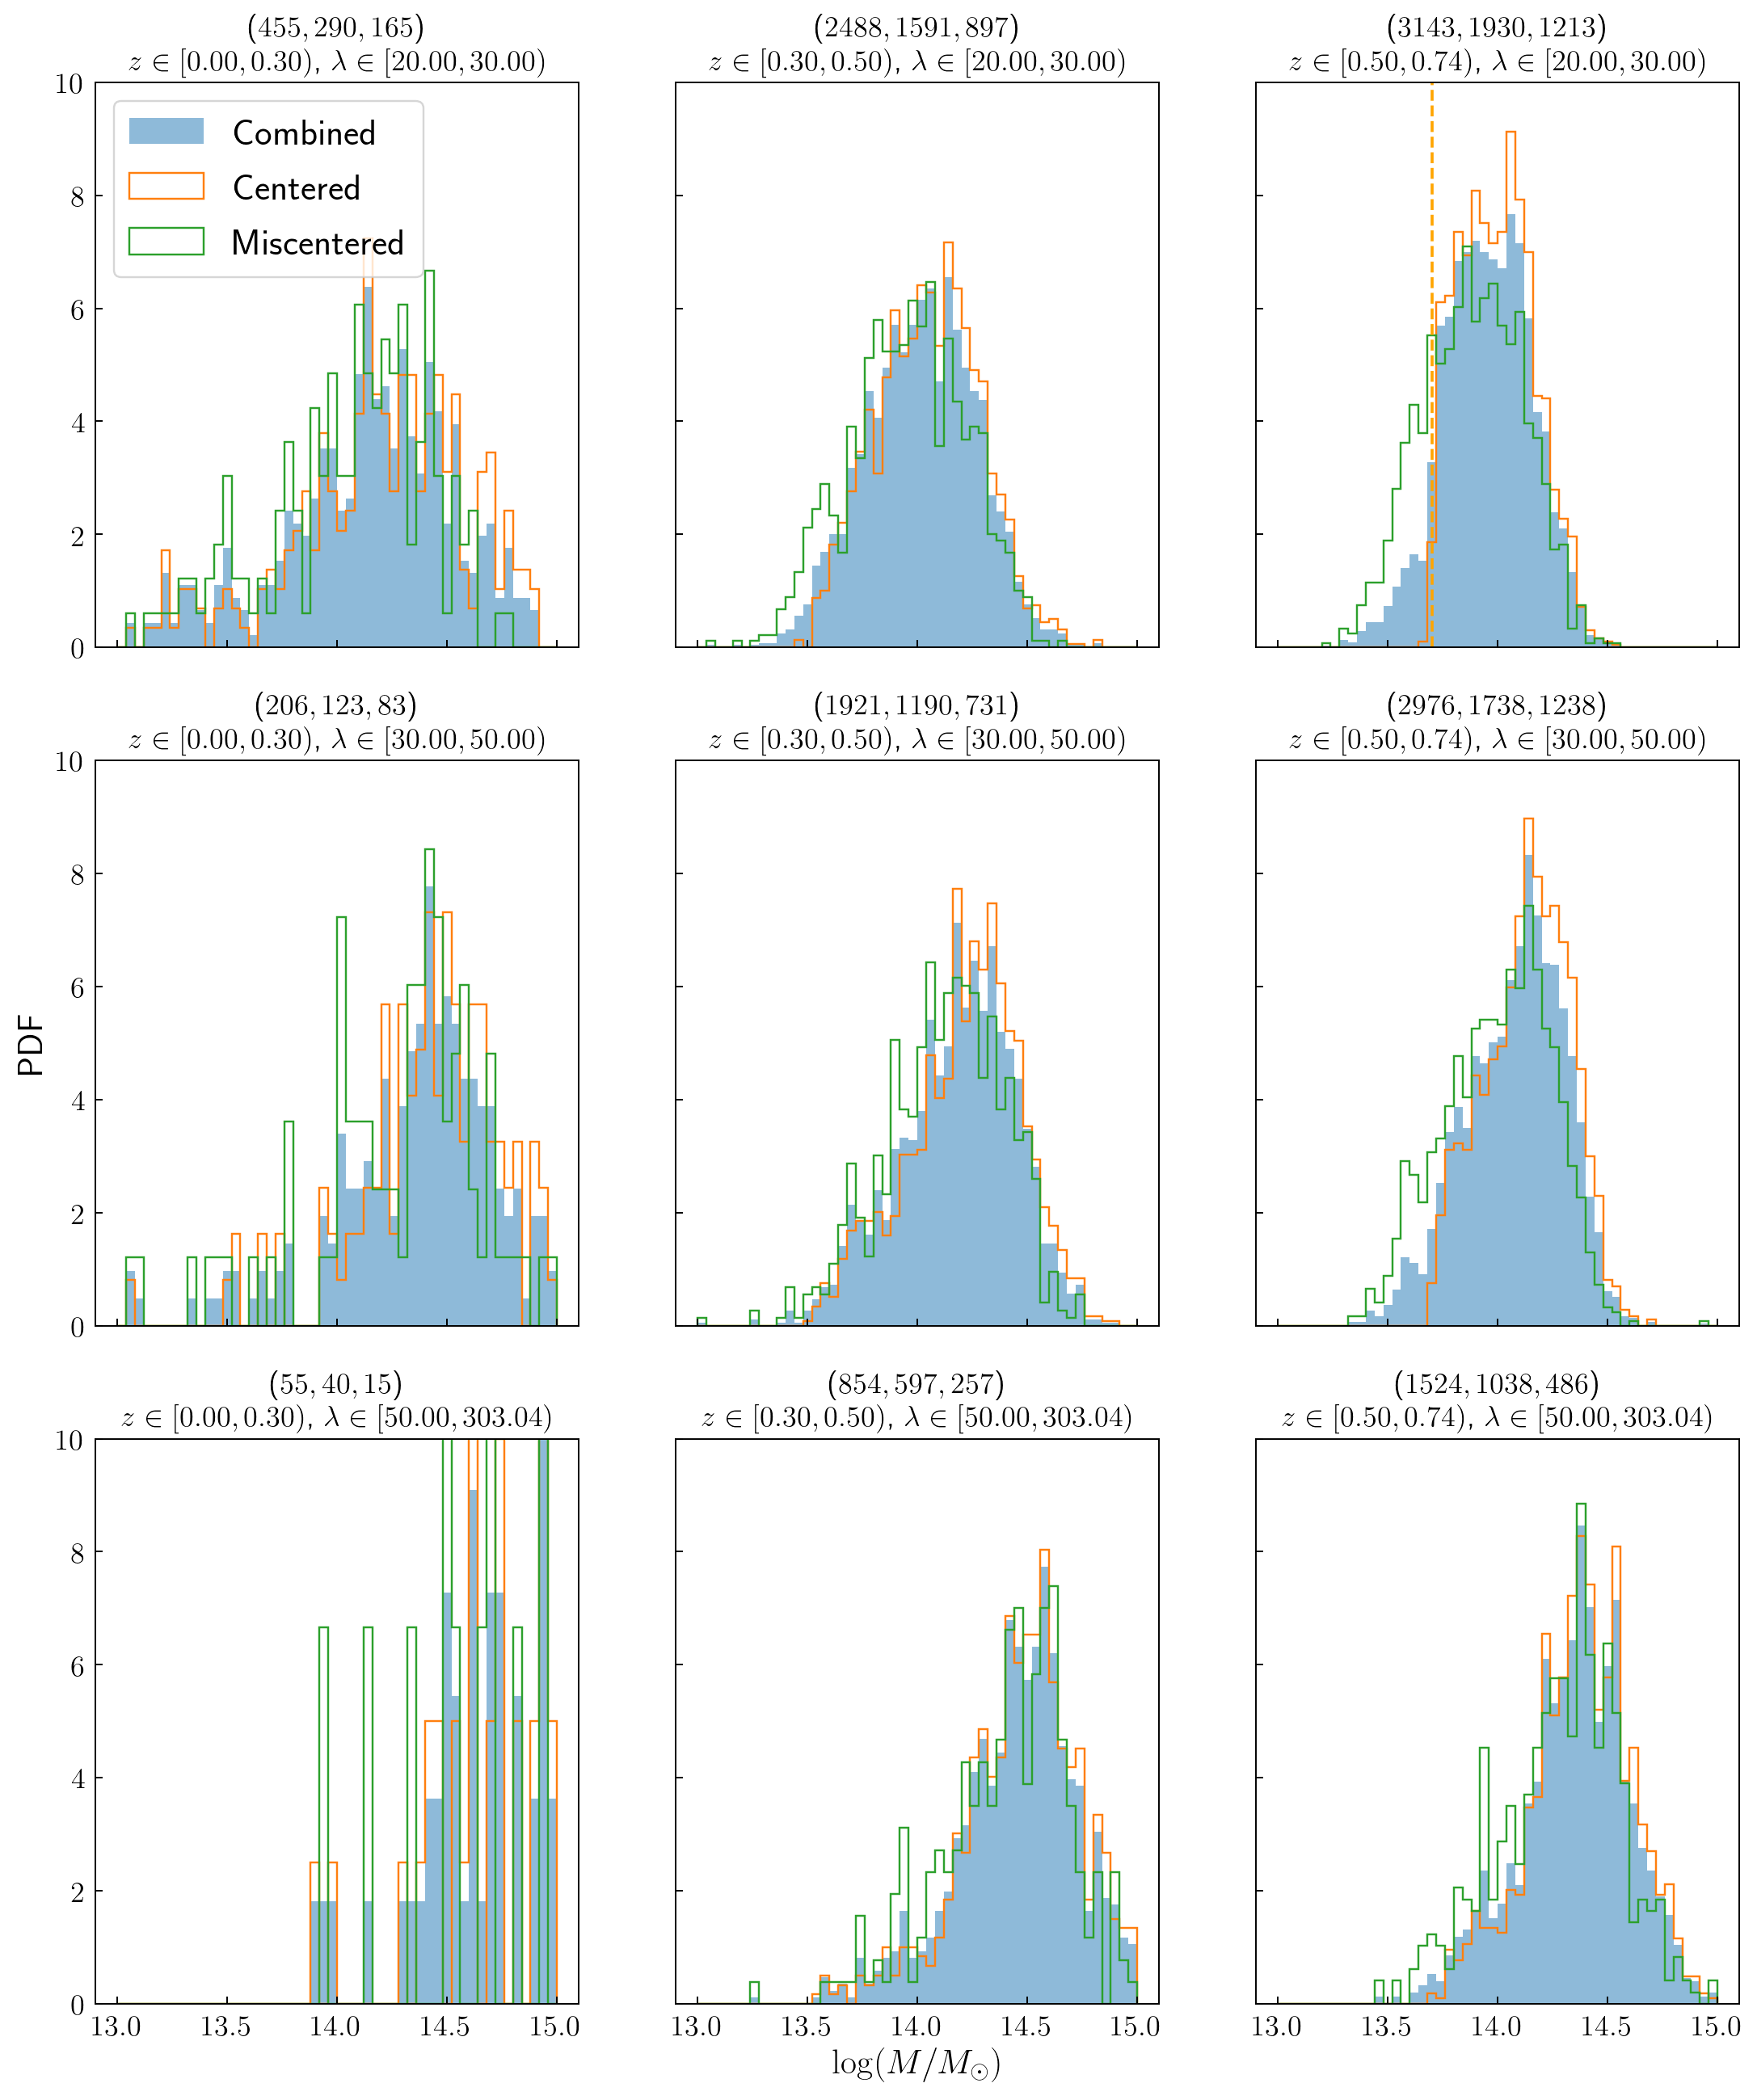

In [67]:
nbins=50
m_range = (13, 15)
fig, ax = plt.subplots(nrows=num_lmda_bins, ncols=num_z_bins, figsize=(15,18), sharex='all', sharey='all',)
for i in range(num_lmda_bins):
    for j in range(num_z_bins):
        redM_halos_bin = redM_halos[ind_bin_2d[i][j]]
        
        #Divide into centered and miscentered
        cent_ind = np.where(redM_halos_bin.centered_flag == 1)
        redM_halos_bin_cent = redM_halos_bin[cent_ind]
        
        miscent_ind = np.where(redM_halos_bin.centered_flag == 0)
        redM_halos_bin_miscent = redM_halos_bin[miscent_ind]
        
        #log mass
        lnM_tot = np.log10(redM_halos_bin.M200B)
        lnM_cent = np.log10(redM_halos_bin_cent.M200B)
        lnM_miscent = np.log10(redM_halos_bin_miscent.M200B)
        
        #Assigning weights to reflect pdf
        weights_tot = np.ones_like(lnM_tot, dtype=float)/len(lnM_tot)* 100
        weights_cent = np.ones_like(lnM_cent, dtype=float)/len(lnM_cent)* 100
        weights_miscent = np.ones_like(lnM_miscent, dtype=float)/len(lnM_miscent)* 100
        
        ax[i,j].hist(lnM_tot, nbins, m_range, alpha=0.5, density=False, weights=weights_tot, label='Combined')
        ax[i,j].hist(lnM_cent, nbins, m_range, density=False, fill=False, label='Centered', linewidth=1, histtype='step', weights=weights_cent)
        ax[i,j].hist(lnM_miscent, nbins, m_range, density=False, fill=False, label='Miscentered', linewidth=1, histtype='step', weights=weights_miscent)
        ax[i,j].tick_params(axis='both', which='major', labelsize=15)
        ax[i,j].set_title('(${0:d}, {1:d}, {2:d}$) \n'.format(len(lnM_tot), len(lnM_cent), len(lnM_miscent)) +\
                         '$z \in [{0:.2f}, {1:.2f})$, $\lambda \in [{2:.2f}, {3:.2f})$'\
                          .format(z_bins[j][0], z_bins[j][1], lmda_bins[i][0], lmda_bins[i][1]), \
                         fontsize=15)
        ax[i,j].set_ylim([0,10])
        
ax[1,0].set_ylabel('PDF', fontsize=18)
ax[2,1].set_xlabel(r'$\log(M/M_{\odot})$', fontsize=18)
ax[0,0].legend(loc='upper left', fontsize=19)
ax[0,2].axvline(13.7, linestyle='dashed', c='orange')

plt.show()

### Divide into centered and miscentered

In [7]:
cent_ind = np.where(redM_halos.centered_flag == 1)
redM_halos_cent = redM_halos[cent_ind]
        
miscent_ind = np.where(redM_halos.centered_flag == 0)
redM_halos_miscent = redM_halos[miscent_ind]

### Combined HMF

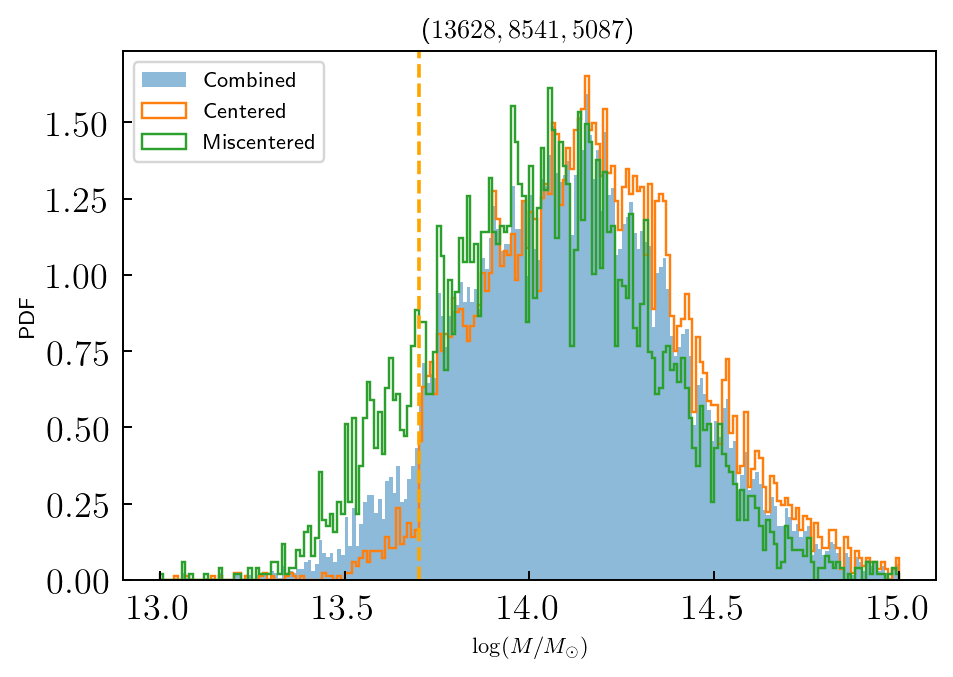

In [32]:
#Testing mass function
lnM_tot = np.log10(redM_halos.M200B)
lnM_cent = np.log10(redM_halos_cent.M200B)
lnM_miscent = np.log10(redM_halos_miscent.M200B)
m_range = (13, 15)

#Assigning weights to reflect pdf
weights_tot = np.ones_like(lnM_tot, dtype=float)/len(lnM_tot)* 100
weights_cent = np.ones_like(lnM_cent, dtype=float)/len(lnM_cent)* 100
weights_miscent = np.ones_like(lnM_miscent, dtype=float)/len(lnM_miscent)* 100

nbins = 200
plt.figure(figsize=(6,4))
plt.hist(lnM_tot, nbins, m_range, alpha=0.5, density=False, weights=weights_tot, label='Combined')
plt.hist(lnM_cent, nbins, m_range, density=False, fill=False, label='Centered', linewidth=1, histtype='step', weights=weights_cent)
plt.hist(lnM_miscent, nbins, m_range, density=False, fill=False, label='Miscentered', linewidth=1, histtype='step', weights=weights_miscent)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.legend(fontsize=9, loc='upper left')
plt.ylabel('PDF')
plt.xlabel(r'$\log(M/M_{\odot})$')
plt.title('(${0:d}, {1:d}, {2:d}$)'.format(len(lnM_tot), len(lnM_cent), len(lnM_miscent)))
plt.axvline(13.7, linestyle='dashed', c='orange')
plt.show()

## Plot richness mass for centered-miscentered

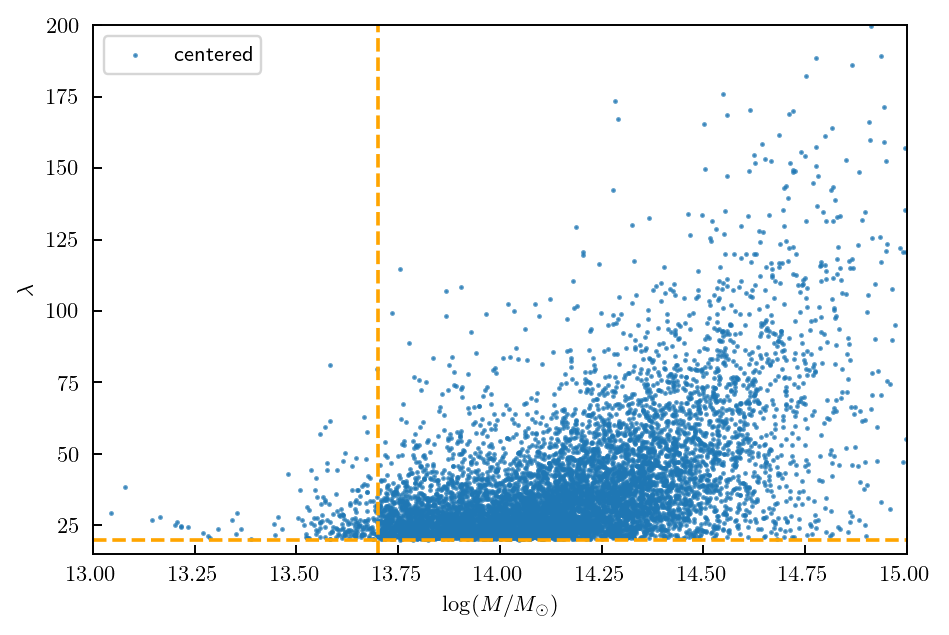

In [39]:
plt.scatter(np.log10(redM_halos_cent.M200B), redM_halos_cent.LAMBDA_CHISQ, s=1, alpha=0.7, label='centered')
#plt.scatter(redM_halos_miscent.M200B, redM_halos_miscent.LAMBDA_CHISQ, s=1, alpha=0.2, label='miscentered')
plt.ylim([15,200]); plt.xlim([13,15])
plt.axvline(13.7, linestyle='dashed', c='orange')
plt.axhline(20.0, linestyle='dashed', c='orange')
plt.ylabel(r'$\lambda$')
plt.xlabel(r'$\log(M/M_{\odot})$')
plt.legend()
plt.show()